# Income Inequality prediction

**Problem Statement:**

The target feature is **income_above_limit** which is a binary-class variable. The objective of this challenge is to create a machine learning model to predict whether an individual earns above or below a certain amount. Your metric for evaluation will be **f1-score**


***Importing necessary Libraries***

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier


# Reset the options to display all rows and columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('data.csv')
df.head()

,ID,age,gender,education,class,education_institute,marital_status,race,is_hispanic,employment_commitment,unemployment_reason,employment_stat,wage_per_hour,is_labor_union,working_week_per_year,industry_code,industry_code_main,occupation_code,occupation_code_main,total_employed,household_stat,household_summary,under_18_family,veterans_admin_questionnaire,vet_benefit,tax_status,gains,losses,stocks_status,citizenship,mig_year,country_of_birth_own,country_of_birth_father,country_of_birth_mother,migration_code_change_in_msa,migration_prev_sunbelt,migration_code_move_within_reg,migration_code_change_in_reg,residence_1_year_ago,old_residence_reg,old_residence_state,importance_of_record,income_above_limit
0,ID_TZ0000,79,Female,High school graduate,NaN,NaN,Widowed,White,All other,Not in labor force,NaN,0,0,NaN,52,0,Not in universe or children,0,NaN,2,Householder,Householder,NaN,NaN,2,Head of household,0,0,292,Native,95,US,US,US,?,?,?,?,NaN,NaN,NaN,1779.74,Below limit
1,ID_TZ0001,65,Female,High school graduate,NaN,NaN,Widowed,White,All other,Children or Armed Forces,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Nonfamily householder,Householder,NaN,NaN,2,Single,0,0,0,Native,94,US,US,US,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,2366.75,Below limit
2,ID_TZ0002,21,Male,12th grade no diploma,Federal government,NaN,Never married,Black,All other,Children or Armed Forces,NaN,0,500,No,15,41,Hospital services,26,Adm support including clerical,4,Child 18+ never marr Not in a subfamily,Child 18 or older,NaN,NaN,2,Single,0,0,0,Native,94,US,US,US,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,1693.42,Below limit
3,ID_TZ0003,2,Female,Children,NaN,NaN,Never married,Asian or Pacific Islander,All other,Children or Armed Forces,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Child <18 never marr not in subfamily,Child under 18 never married,Both parents present,NaN,0,Nonfiler,0,0,0,Native,94,US,India,India,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,1380.27,Below limit
4,ID_TZ0004,70,Male,High school graduate,NaN,NaN,Married-civilian spouse present,White,All other,Not in labor force,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Spouse of householder,Spouse of householder,NaN,NaN,2,Joint both 65+,0,0,0,Native,95,US,US,US,?,?,?,?,NaN,NaN,NaN,1580.79,Below limit


In [3]:
#checking data shape and all present column names  

def dataUndersanding(data):
    print("\033[1mData Shape: \033[0m", data.shape)  #\033[1mThis text is bold\033[0m
    print("\033[1mData Duplicated Count:\033[0m", data.duplicated().sum())
    print("\033[1m=====data Information:=====\033[0m")
    display(data.info())
    print("\033[1m=====Statastical Analysis of Numeric columns: =====\033[0m")
    display(data.describe().T)
    print("\033[1m=====Statastical Analysis of Categorical columns: =====\033[0m")
    display(data.describe(include = "object").T)
    print("\033[1m=====Missing data column wise count:=====\033[0m")
#     display(data.isna().sum())
    missing_data = data.isnull().sum().to_frame(name='Missing Count')
    missing_data['Percentage Missing'] = (missing_data['Missing Count'] / len(data)) * 100
    display(missing_data)
    print("\033[1m=====Unique values per column:=====\033[0m")
    display(data.nunique())


dataUndersanding(df)

Data Shape:  (209499, 43)
Data Duplicated Count: 0
=====data Information:=====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209499 entries, 0 to 209498
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              209499 non-null  object 
 1   age                             209499 non-null  int64  
 2   gender                          209499 non-null  object 
 3   education                       209499 non-null  object 
 4   class                           104254 non-null  object 
 5   education_institute             13302 non-null   object 
 6   marital_status                  209499 non-null  object 
 7   race                            209499 non-null  object 
 8   is_hispanic                     209499 non-null  object 
 9   employment_commitment           209499 non-null  object 
 10  unemployment_reason             6520 non-null    object 
 11 

None

=====Statastical Analysis of Numeric columns: =====


,count,mean,std,min,25%,50%,75%,max
age,209499.0,34.518728,22.306738,0.00,15.00,33.00,50.00,90.0
employment_stat,209499.0,0.176760,0.555562,0.00,0.00,0.00,0.00,2.0
wage_per_hour,209499.0,55.433487,276.757327,0.00,0.00,0.00,0.00,9999.0
working_week_per_year,209499.0,23.158850,24.397963,0.00,0.00,8.00,52.00,52.0
industry_code,209499.0,15.332398,18.049655,0.00,0.00,0.00,33.00,51.0
occupation_code,209499.0,11.321734,14.460839,0.00,0.00,0.00,26.00,46.0
total_employed,209499.0,1.956067,2.365154,0.00,0.00,1.00,4.00,6.0
vet_benefit,209499.0,1.515854,0.850853,0.00,2.00,2.00,2.00,2.0
gains,209499.0,435.926887,4696.359500,0.00,0.00,0.00,0.00,99999.0
losses,209499.0,36.881737,270.383302,0.00,0.00,0.00,0.00,4608.0


=====Statastical Analysis of Categorical columns: =====


,count,unique,top,freq
ID,209499,209499,ID_TZ0000,1
gender,209499,2,Female,108784
education,209499,17,High school graduate,50627
class,104254,8,Private,75617
education_institute,13302,2,High school,7247
marital_status,209499,7,Never married,90723
race,209499,5,White,175709
is_hispanic,209499,10,All other,180404
employment_commitment,209499,8,Children or Armed Forces,129789
unemployment_reason,6520,5,Other job loser,2242


=====Missing data column wise count:=====


,Missing Count,Percentage Missing
ID,0,0.000000
age,0,0.000000
gender,0,0.000000
education,0,0.000000
class,105245,50.236517
education_institute,196197,93.650566
marital_status,0,0.000000
race,0,0.000000
is_hispanic,0,0.000000
employment_commitment,0,0.000000


=====Unique values per column:=====


ID                                209499
age                                   91
gender                                 2
education                             17
class                                  8
education_institute                    2
marital_status                         7
race                                   5
is_hispanic                           10
employment_commitment                  8
unemployment_reason                    5
employment_stat                        3
wage_per_hour                       1232
is_labor_union                         2
working_week_per_year                 53
industry_code                         52
industry_code_main                    24
occupation_code                       47
occupation_code_main                  14
total_employed                         7
household_stat                        38
household_summary                      8
under_18_family                        4
veterans_admin_questionnaire           2
vet_benefit     

- ID is unique identifier 
- Columns education_institute, unemployment_reason, is_labor_union, under_18_family, veterans_admin_questionnaire, 
  old_residence_reg, old_residence_state having above 70%, 90% missing value.
  

In [4]:
ids = df['ID']

In [6]:
df.columns

Index(['ID', 'age', 'gender', 'education', 'class', 'education_institute',
       'marital_status', 'race', 'is_hispanic', 'employment_commitment',
       'unemployment_reason', 'employment_stat', 'wage_per_hour',
       'is_labor_union', 'working_week_per_year', 'industry_code',
       'industry_code_main', 'occupation_code', 'occupation_code_main',
       'total_employed', 'household_stat', 'household_summary',
       'under_18_family', 'veterans_admin_questionnaire', 'vet_benefit',
       'tax_status', 'gains', 'losses', 'stocks_status', 'citizenship',
       'mig_year', 'country_of_birth_own', 'country_of_birth_father',
       'country_of_birth_mother', 'migration_code_change_in_msa',
       'migration_prev_sunbelt', 'migration_code_move_within_reg',
       'migration_code_change_in_reg', 'residence_1_year_ago',
       'old_residence_reg', 'old_residence_state', 'importance_of_record',
       'income_above_limit'],
      dtype='object')

In [7]:
df['income_above_limit'].value_counts()

income_above_limit
Below limit    196501
Above limit     12998
Name: count, dtype: int64

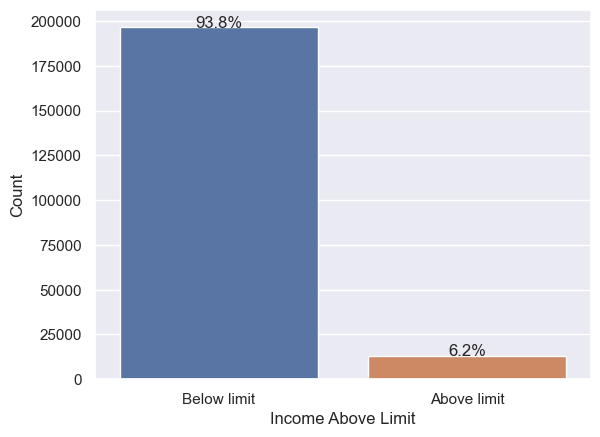

In [8]:
# Create a countplot
sns.set(style="darkgrid")
ax = sns.countplot(x="income_above_limit", data=df)

# Calculate percentage values
total_count = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)  # Calculate the percentage
    x = p.get_x() + p.get_width() / 2  # Find the center of the bar
    y = p.get_height()  # Get the height of the bar
    ax.annotate(percentage, (x, y), ha='center', fontsize=12)

plt.xlabel("Income Above Limit")
plt.ylabel("Count")
plt.show()

***Checking Age distribution with Income equilities***

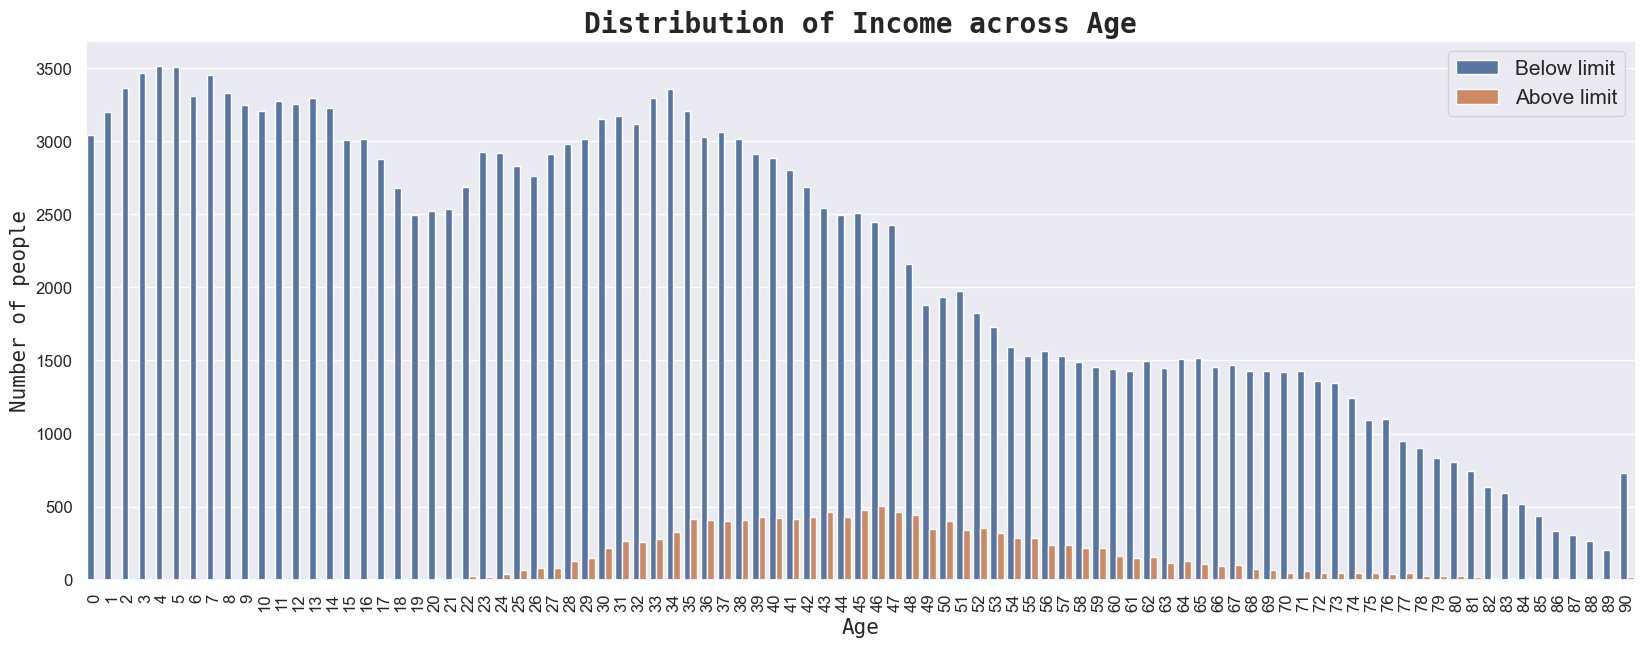

In [9]:
df_age = df.copy(deep=True)
# Creating a countplot of income across age
plt.figure(figsize=(20, 7))
sns.countplot(x=df['age'], hue=df['income_above_limit'])
plt.title('Distribution of Income across Age', fontdict={
          'fontname': 'Monospace', 'fontsize': 20, 'fontweight': 'bold'})
plt.xlabel('Age', fontdict={'fontname': 'Monospace', 'fontsize': 15})
plt.ylabel('Number of people', fontdict={
           'fontname': 'Monospace', 'fontsize': 15})
plt.tick_params(labelsize=12)
plt.xticks(rotation=90)
plt.legend(loc=1, prop={'size': 15})
plt.show()

In [10]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, float('inf')]  # Define your bins here
labels = ["1 to 10", "11 to 20", "21 to 30", "31 to 40", "41 to 50", "51 to 60", "61 to 70", "71 and above"]


df_age['Age Category'] = pd.cut(df_age['age'], bins=bins, labels=labels)

In [11]:
# df_age['Age Category'].value_counts()

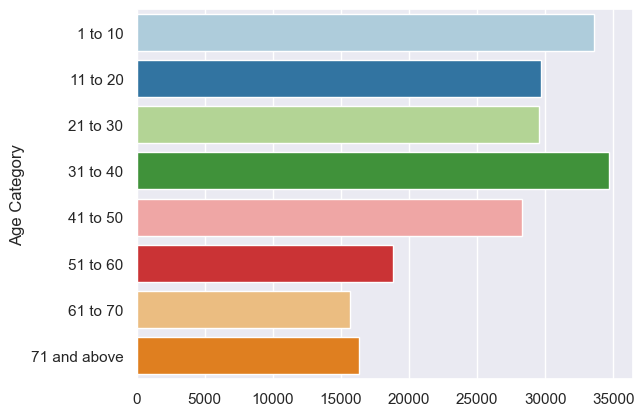

In [12]:
ages = df_age['Age Category'].value_counts()

sns.barplot(x=ages.values, y=ages.index, palette='Paired');

In [13]:
print('Income below limit for people Age limit 31 to 40:',len(df_age.loc[(df_age['Age Category']=='31 to 40') & 
                                                                (df_age['income_above_limit']=='Below limit')])/len(df_age.loc[(df_age['Age Category']=='31 to 40')]) * 100, '%')
print('Income above limit for people Age limit 31 to 40:',len(df_age.loc[(df_age['Age Category']=='31 to 40') & 
                                                                (df_age['income_above_limit']=='Above limit')])/len(df_age.loc[(df_age['Age Category']=='31 to 40')]) * 100, '%')

Income below limit for people Age limit 31 to 40: 89.58207147183526 %
Income above limit for people Age limit 31 to 40: 10.417928528164747 %


People in Age limit group 31 to 40 having income above limit 10%

***Plotting categories countplot with Income equilities***

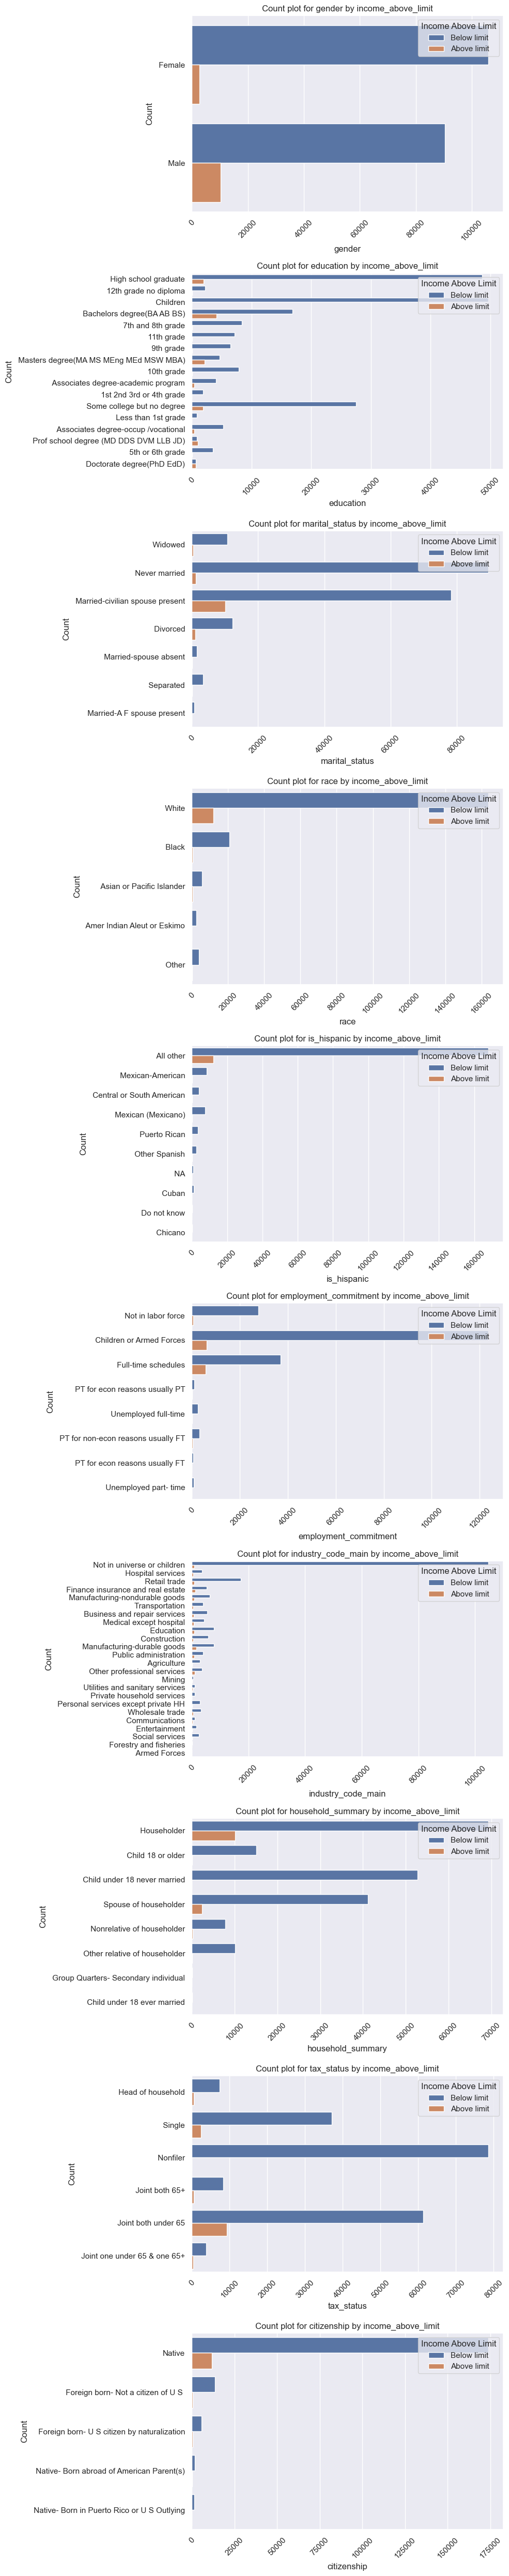

In [14]:

# List of categorical columns
categorical_columns = [
    'gender',
    'education',
    'marital_status',
    'race',
    'is_hispanic',
    'employment_commitment',
    'industry_code_main',
    'household_summary',
    'tax_status',
    'citizenship',
]

# Create subplots
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 5 * len(categorical_columns)))
plt.subplots_adjust(hspace=0.5)
# Create a figure with two subplots arranged horizontally
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Iterate through categorical columns and create count plots
for i, col in enumerate(categorical_columns):
    ax = axes[i]
    sns.countplot(data=df, y=col, hue='income_above_limit', ax=ax)
    ax.set_title(f'Count plot for {col} by income_above_limit')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend(title='Income Above Limit', loc='upper right')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show();


In [15]:
# df.columns

In [16]:
print('Males with income below limit:',len(df.loc[(df['gender']==' Male') & (df['income_above_limit']=='Below limit')])/len(df.loc[(df['gender']==' Male')]) * 100, '%')
print('Females with income below limit:',len(df.loc[(df['gender']!=' Male') & (df['income_above_limit']=='Below limit')])/len(df.loc[(df['gender']!=' Male')]) * 100, '%')

Males with income below limit: 89.86248324479969 %
Females with income below limit: 97.43712310633916 %


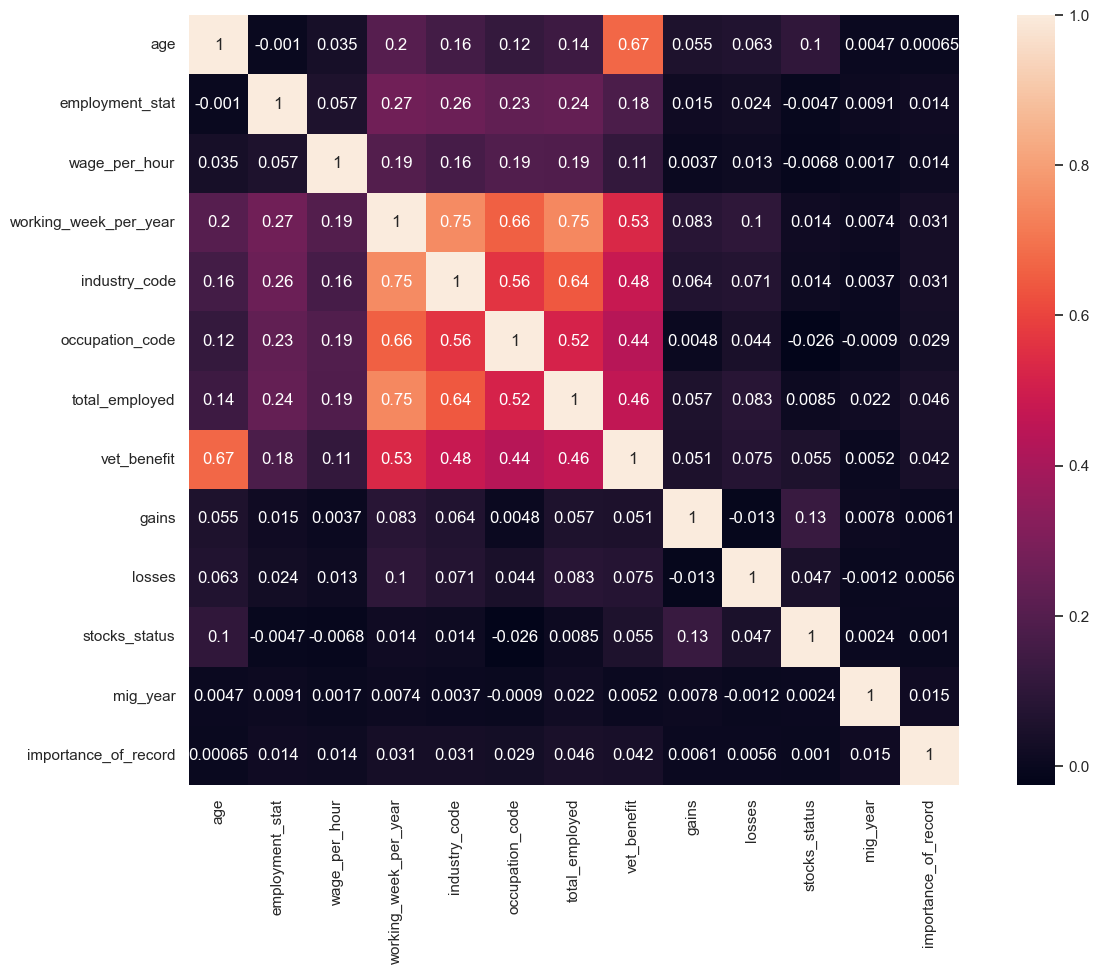

In [17]:
numeric_columns = df.select_dtypes(include=['number'])

corr = numeric_columns.corr(method='pearson')

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(corr, square=True,annot=True)
plt.show()

Some income related features are correlated with each other 

In [19]:
# df.columns

***Analyzing missing data***

<Axes: >

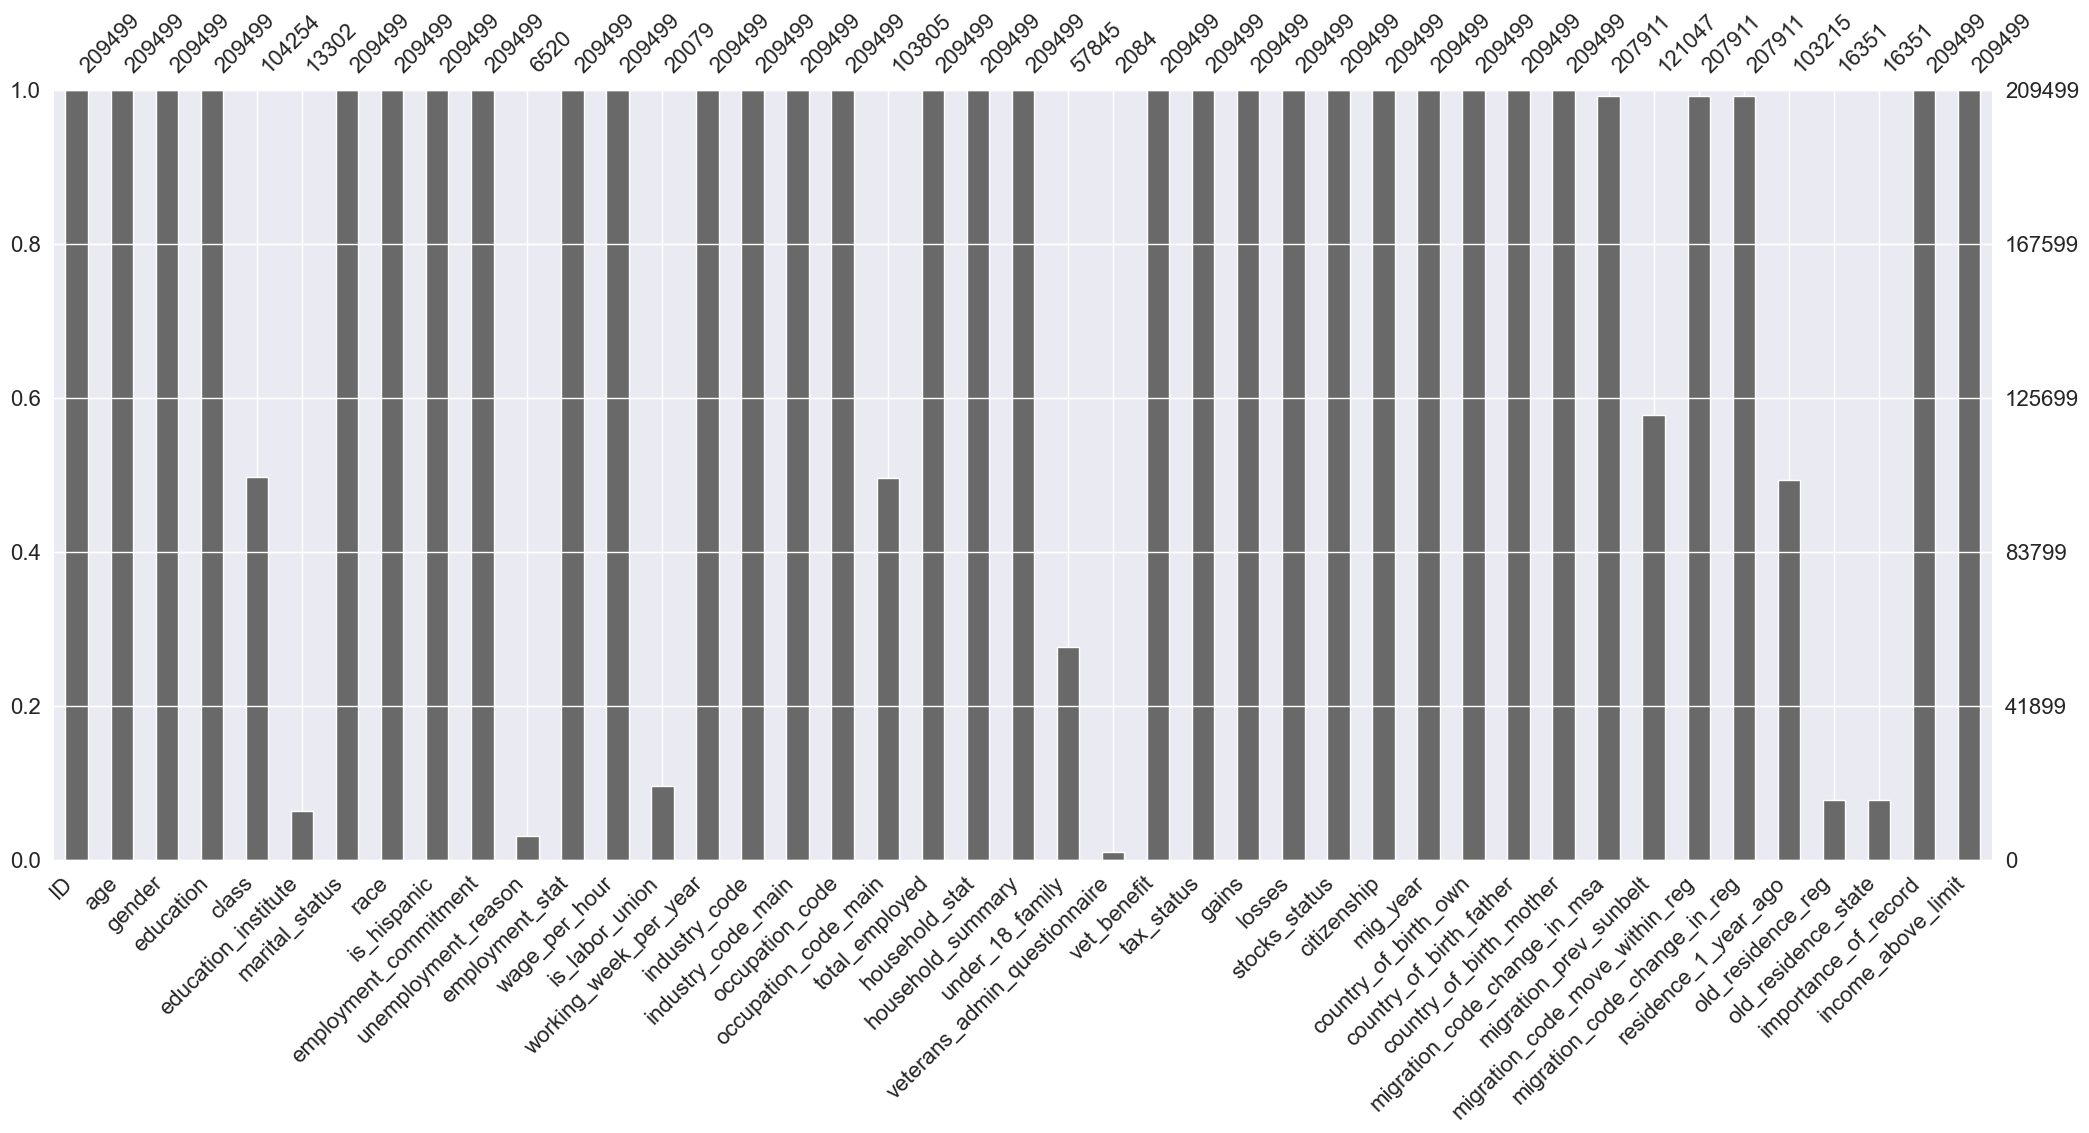

In [20]:
msno.bar(df)

dropping column with 50% missing value present 

In [21]:
# dropping columns with too much nan values i.e more than 50%
nan_cols_drop  = []
for cols in df.columns:
    if df[cols].isna().sum()/df.shape[0] >0.5:
        nan_cols_drop.append(cols)
        
        
df = df.drop(nan_cols_drop,axis=1)

In [22]:
round((df.isna().sum() / df.shape[0]) * 100, 2).astype(str) + ' %'

ID                                  0.0 %
age                                 0.0 %
gender                              0.0 %
education                           0.0 %
marital_status                      0.0 %
race                                0.0 %
is_hispanic                         0.0 %
employment_commitment               0.0 %
employment_stat                     0.0 %
wage_per_hour                       0.0 %
working_week_per_year               0.0 %
industry_code                       0.0 %
industry_code_main                  0.0 %
occupation_code                     0.0 %
total_employed                      0.0 %
household_stat                      0.0 %
household_summary                   0.0 %
vet_benefit                         0.0 %
tax_status                          0.0 %
gains                               0.0 %
losses                              0.0 %
stocks_status                       0.0 %
citizenship                         0.0 %
mig_year                          

<div class="alert alert-danger" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 

Country of birth own, father, mother, migration related columns are not some columns that may have any affect on model

In [23]:
df = df.drop(['country_of_birth_own', 'country_of_birth_father','country_of_birth_mother',
              'migration_code_change_in_msa','migration_prev_sunbelt','migration_code_move_within_reg', 
             'migration_code_change_in_reg'],axis=1)

***Feature and Lebel***

In [24]:
x,y = df.drop(['ID','income_above_limit'],axis=1),df['income_above_limit']

***RandomSampler***

In [25]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)


X_random_resampled, Y_random_resampled = ros.fit_resample(x,y)

In [26]:
print('The class Imbalance in the data is given below')
print(Y_random_resampled.value_counts(),'\n')
print('The class imbalance in terms of percentage is given below ')
print(f"{Y_random_resampled.value_counts(normalize=True)*100}")

The class Imbalance in the data is given below
income_above_limit
Below limit    196501
Above limit    196501
Name: count, dtype: int64 

The class imbalance in terms of percentage is given below 
income_above_limit
Below limit    50.0
Above limit    50.0
Name: proportion, dtype: float64


***Train test split***

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_random_resampled, Y_random_resampled, test_size=0.25, random_state=42)

In [29]:
X_train.shape,  X_test.shape

((294751, 24), (98251, 24))

# Encoding

In [30]:
Y_train.replace({'Below limit':0,'Above limit':1}, inplace=True)
Y_test.replace({'Below limit':0,'Above limit':1}, inplace=True)

In [ ]:

# X_train_enc = pd.get_dummies(data = X_train, columns = ['gender','education', 'marital_status', 'race', 'is_hispanic',
#                                                           'employment_commitment', 'industry_code_main', 'household_stat',
#                                                           'household_summary', 'tax_status', 'citizenship'], 
#                          prefix = "is",  dtype= int)


# X_test_enc = pd.get_dummies(data = X_test, columns = ['gender','education', 'marital_status', 'race', 'is_hispanic',
#                                                           'employment_commitment', 'industry_code_main', 'household_stat',
#                                                           'household_summary', 'tax_status', 'citizenship'], 
#                         prefix = "is", dtype= int)

In [31]:
cat_col = []
for col in X_train.columns:
    if X_train[col].dtype == 'O':
#         print(col)
        cat_col.append(col)

In [32]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

X_train[cat_col] = X_train[cat_col].apply(label_encoder.fit_transform)
X_test[cat_col] = X_test[cat_col].apply(label_encoder.fit_transform)

In [ ]:
# X_train.shape,  X_test.shape

# Baseline modelling

***1) Random Forest classifier***

In [33]:
ran_for = RandomForestClassifier(random_state=42)
ran_for.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [34]:
Y_pred_ran_for = ran_for.predict(X_test)

In [35]:
print('Random Forest Classifier:')
print('F1 score:', round(f1_score(Y_test, Y_pred_ran_for), 2))
print('Recall score:', round(recall_score(Y_test, Y_pred_ran_for), 2))
print('Precision score:', round(precision_score(Y_test, Y_pred_ran_for), 2))


Random Forest Classifier:
F1 score: 0.99
Recall score: 1.0
Precision score: 0.98


In [36]:
print(classification_report(Y_test, Y_pred_ran_for))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49464
           1       0.98      1.00      0.99     48787

    accuracy                           0.99     98251
   macro avg       0.99      0.99      0.99     98251
weighted avg       0.99      0.99      0.99     98251



In [43]:
confusion_matrix(Y_test, Y_pred_ran_for)

array([[48558,   906],
       [  156, 48631]], dtype=int64)

***2) XGBoost***

In [37]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, Y_train)

Y_pred_xgb = xgb.predict(X_test)

In [38]:
print('XGBoost Classifier:')
print('F1 score:', round(f1_score(Y_test, Y_pred_xgb), 2))
print('Recall score:', round(recall_score(Y_test, Y_pred_xgb), 2))
print('Precision score:', round(precision_score(Y_test, Y_pred_xgb), 2))


XGBoost Classifier:
F1 score: 0.89
Recall score: 0.86
Precision score: 0.92


In [39]:
print(classification_report(Y_test, Y_pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     49464
           1       0.92      0.86      0.89     48787

    accuracy                           0.89     98251
   macro avg       0.89      0.89      0.89     98251
weighted avg       0.89      0.89      0.89     98251



In [44]:
confusion_matrix(Y_test, Y_pred_xgb)

array([[45670,  3794],
       [ 6778, 42009]], dtype=int64)

***3) Extra Trees***

In [40]:
trees = ExtraTreesClassifier()
trees.fit(X_train, Y_train)

Y_pred_trees = trees.predict(X_test)

In [41]:
print('svc_ Classifier:')
print('F1 score:', round(f1_score(Y_test, Y_pred_trees), 2))
print('Recall score:', round(recall_score(Y_test, Y_pred_trees), 2))
print('Precision score:', round(precision_score(Y_test, Y_pred_trees), 2))


svc_ Classifier:
F1 score: 0.99
Recall score: 0.99
Precision score: 0.99


In [42]:
print(classification_report(Y_test, Y_pred_trees))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49464
           1       0.99      0.99      0.99     48787

    accuracy                           0.99     98251
   macro avg       0.99      0.99      0.99     98251
weighted avg       0.99      0.99      0.99     98251



In [45]:
confusion_matrix(Y_test, Y_pred_trees)

array([[49002,   462],
       [  402, 48385]], dtype=int64)